In [1]:
import matplotlib
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [1]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [2]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/Training", 
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
dataset

In [1]:
class_names=dataset.class_names
class_names


NameError: name 'dataset' is not defined

In [ ]:
len(dataset)
# coz each batch is 32 

68

2022-01-24 21:51:39.826850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


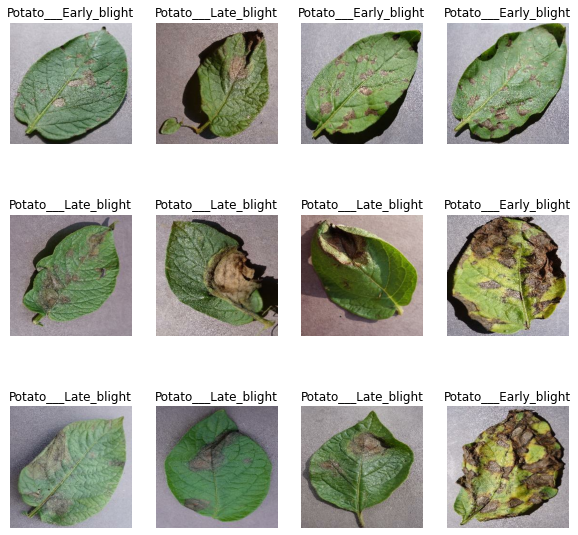

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):    
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        #print(image_batch[0].shape)
        plt.title(class_names[lable_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

68

80% ==> training
20% ==> 10% validation, 10% test

In [ ]:
train_set = 0.8

len(dataset)*train_set

54.400000000000006

In [ ]:
train_ds=dataset.take(54)
len(train_ds)

54

In [ ]:
dataset.skip(54) #similar to arr[54:]
test_ds=dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds.skip(6)

<SkipDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def partition_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12) #seed is for predictibility
    train_size=int(train_split * ds_size)
    val_size=int(val_split*ds_size)
   

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    


    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = partition_dataset(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
# read image fro disk and for next iteratio  when you need the same image it will keep the image in the memory
# prefetching uses cpu and gpu simultaneously so that there is no loss of time in that. 
# CACHE and PREFETCH improves the performance
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,
    #during prediction if the supplied image is not 256*256, then this will take care of that
    layers.experimental.preprocessing.Rescaling(1.0/255)
    #to get value between 0 to 1
])

AUGMENTATION layer:

if you have 1 image, you change its orientation by say rotating it, changing the contrast, flipping it horizontally, zooming the image, etc and thus get 5 images out of one image and thus make the model robust thus when predicting in wild, if someone gives a rotated image, the model knows how to predict that.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
]) 

In [ ]:
input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=3

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)), #stacking maxpooling and conv2d layers
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),# a dense layer of 64 neurons
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] #track the training process
)

In [ ]:
#record history of all the records
history = model.fit(
    train_ds, 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
54/54 [==============================] - 115s 2s/step - loss: 0.4593 - accuracy: 0.8177 - val_loss: 0.3636 - val_accuracy: 0.8646
Epoch 2/50
54/54 [==============================] - 127s 2s/step - loss: 0.2554 - accuracy: 0.8981 - val_loss: 0.1106 - val_accuracy: 0.9792
Epoch 3/50
54/54 [==============================] - 101s 2s/step - loss: 0.2507 - accuracy: 0.9080 - val_loss: 0.5781 - val_accuracy: 0.7656
Epoch 4/50
54/54 [==============================] - 143s 3s/step - loss: 0.1677 - accuracy: 0.9358 - val_loss: 0.1104 - val_accuracy: 0.9479
Epoch 5/50
54/54 [==============================] - 137s 3s/step - loss: 0.1661 - accuracy: 0.9421 - val_loss: 0.1123 - val_accuracy: 0.9635
Epoch 6/50
54/54 [==============================] - 130s 2s/step - loss: 0.1766 - accuracy: 0.9381 - val_loss: 0.1389 - val_accuracy: 0.9531
Epoch 7/50
54/54 [==============================] - 1158s 10s/step - loss: 0.0893 - accuracy: 0.9734 - val_loss: 0.0946 - val_accuracy: 0.9740
Epoch 8/50


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 466ms/step - loss: 0.0208 - accuracy: 0.9922


In [ ]:
scores

[0.020774200558662415, 0.9921875]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.8177083134651184,
 0.8981481194496155,
 0.9079861044883728,
 0.9357638955116272,
 0.9421296119689941,
 0.9380787014961243,
 0.9733796119689941,
 0.9745370149612427,
 0.9716435074806213,
 0.9785879850387573,
 0.9733796119689941,
 0.9751157164573669,
 0.9704861044883728,
 0.9728009104728699,
 0.9872685074806213,
 0.9722222089767456,
 0.9780092835426331,
 0.9670138955116272,
 0.984375,
 0.9774305820465088,
 0.9895833134651184,
 0.9872685074806213,
 0.9756944179534912,
 0.9809027910232544,
 0.9884259104728699,
 0.9878472089767456,
 0.9895833134651184,
 0.9837962985038757,
 0.9837962985038757,
 0.9907407164573669,
 0.9947916865348816,
 0.9918981194496155,
 0.9774305820465088,
 0.9918981194496155,
 0.9820601940155029,
 0.9866898059844971,
 0.9774305820465088,
 0.9629629850387573,
 0.9785879850387573,
 0.9866898059844971,
 0.9924768805503845,
 0.9936342835426331,
 0.9918981194496155,
 0.9918981194496155,
 0.9901620149612427,
 0.9924768805503845,
 0.9849537014961243,
 0.9942129850387573,
 0

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

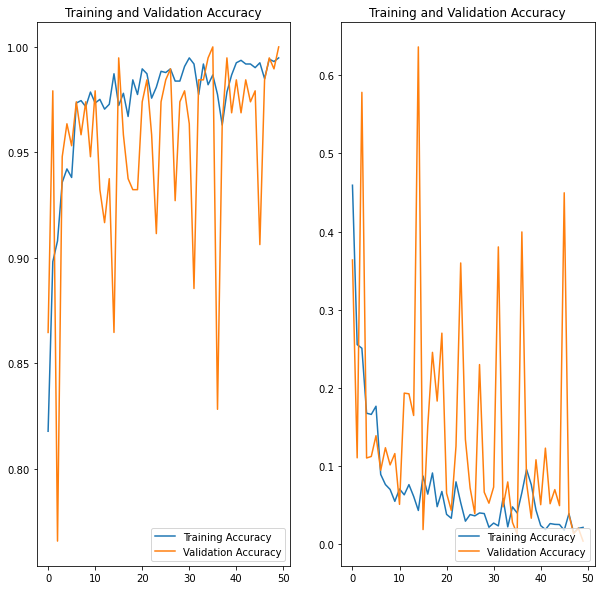

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

First image to predict: 
Actual Image Label:  Potato___Early_blight
Predicted Image Label:  Potato___Early_blight


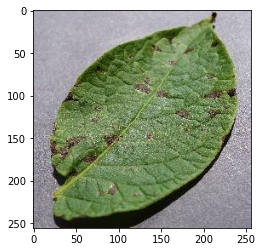

In [ ]:
import numpy as np

for image_batch, lable_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = lable_batch[0].numpy()

    print("First image to predict: ")
    plt.imshow(first_image)
    print("Actual Image Label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch) # predicts the classes having the respective probability
    print("Predicted Image Label: ", class_names[np.argmax(batch_prediction[0])]) # argmax gives the class haviung max probability
    

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # creating a batch 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    pred_confidence = round(100* (np.max(predictions[0])),2)

    return predicted_class, pred_confidence



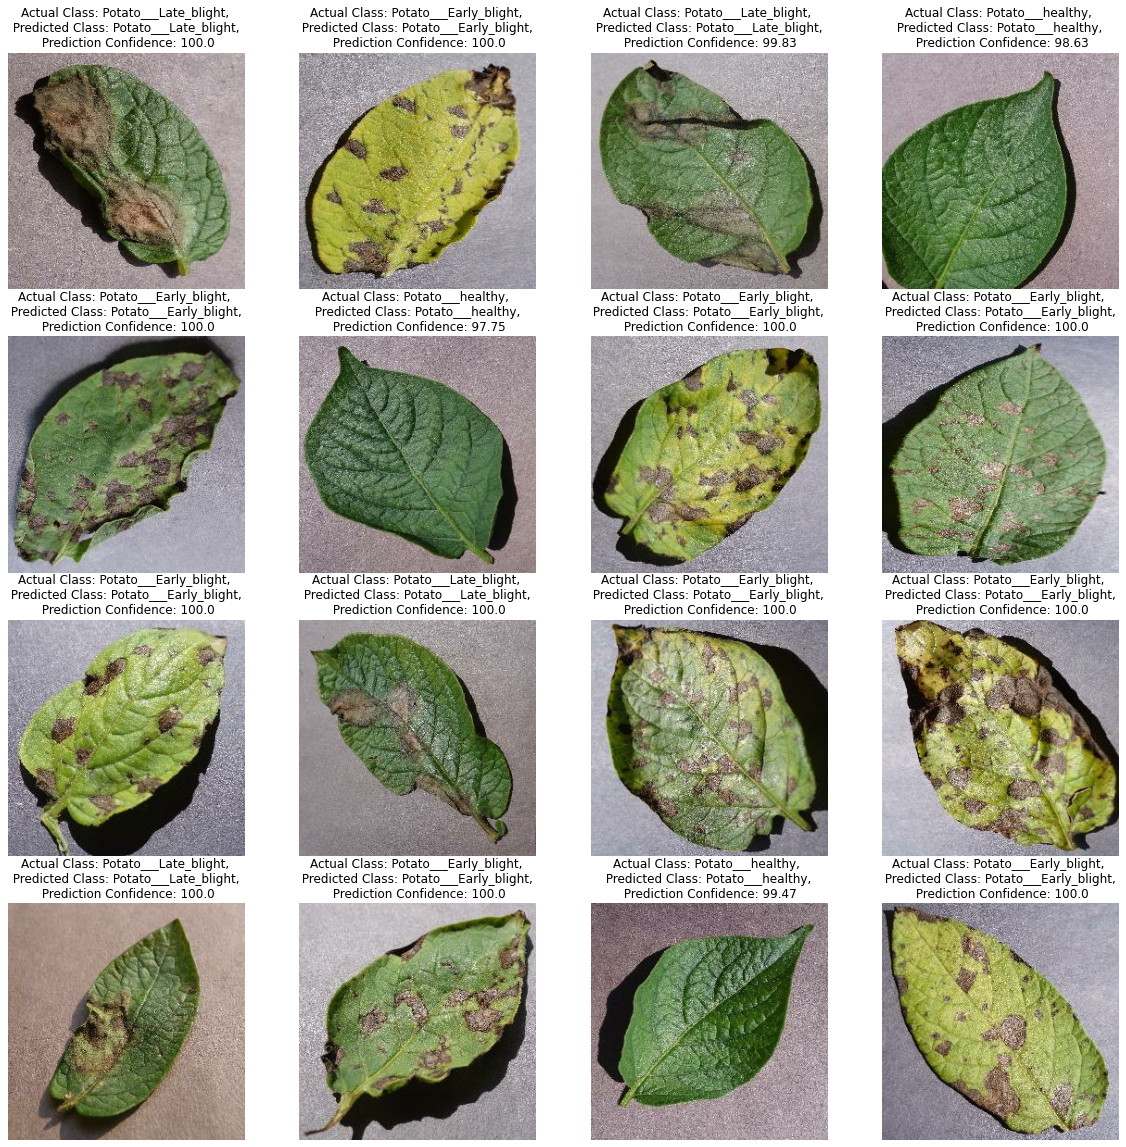

In [ ]:
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        predicted_class, pred_confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        #give title using python format striing
        plt.title(f"Actual Class: {actual_class}, \n Predicted Class: {predicted_class}, \n Prediction Confidence: {pred_confidence}")

In [ ]:
#auto increment model version

import os
model_version= max([int (i) for i in os.listdir("models")] )+1# converting os.listdir("models") to int

In [ ]:
model_version = 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets
